In [60]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [62]:
# 生成数据集
x1 = torch.rand(10000, 1)
x2 = torch.rand(10000, 1)
x3 = torch.rand(10000, 1)
x1.shape, x2.shape, x3.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]), torch.Size([10000, 1]))

In [63]:
# 生成标签
y1 = ((x1 + x2 + x3) < 1).float()
y2 = ((1 < (x1 + x2 + x3)) & (x1 + x2 + x3 < 2)).float()
y3 = (2 < (x1 + x2 + x3)).float()
y1.shape, y2.shape, y3.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]), torch.Size([10000, 1]))

In [64]:
# 构建模型
Data = torch.cat([x1, x2, x3, y1, y2, y3], dim=1)
Data = Data.to('mps')
Data.shape

torch.Size([10000, 6])

In [65]:
train_size = int(len(Data) * 0.7) # 70%的数据用于训练
test_size = len(Data) - train_size # 30%的数据用于测试
Data = Data[torch.randperm(Data.size(0)), :] # 打乱数据
train_data = Data[:train_size, :]   # 前70%为训练集
test_data = Data[train_size:, :]    # 后30%为测试集
train_data.shape, test_data.shape

(torch.Size([7000, 6]), torch.Size([3000, 6]))

In [66]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential( # 三层神经网络
            nn.Linear(3, 5), # 输入层
            nn.ReLU(), 
            nn.Linear(5, 5), # 隐藏层
            nn.ReLU(),
            nn.Linear(5, 5), # 隐藏层
            nn.ReLU(),
            nn.Linear(5, 3) # 输出层
        )
        
    def forward(self, x):
        y = self.net(x) # 前向传播
        return y # 返回预测值


In [67]:
model = DNN().to('mps') # 实例化模型
model

DNN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)

In [68]:
# 训练模型
learning_rate = 0.01 # 学习率
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # 优化器

100%|██████████| 1000/1000 [00:03<00:00, 278.17it/s]


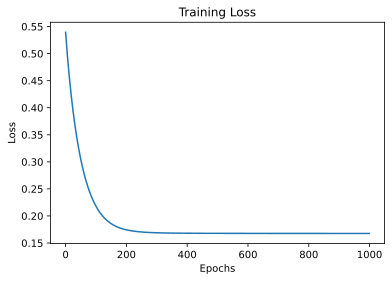

In [69]:
from tqdm import *

epochs = 1000 # 迭代次数
losses = [] # 记录损失值

X = train_data[:, :3] # 输入
Y = train_data[:, 3:] # 标签

for epoch in trange(epochs):
    Pred = model(X) # 预测值
    loss = nn.MSELoss()(Pred, Y) # 计算损失
    losses.append(loss.item()) # 记录损失值 
    optimizer.zero_grad() # 梯度清零
    loss.backward() # 反向传播 
    optimizer.step() # 更新参数

Fig = plt.figure(figsize=(6, 4))
plt.plot(range(epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [70]:
x = test_data[:, :3] # 测试集输入
y = test_data[:, 3:] # 测试集标签

with torch.no_grad():
    pred = model(x) # 预测值
    pred[:, torch.argmax(pred, dim=1)] = 1 # 最大值为1
    pred[pred != 1] = 0 # 其他值为0
    correct = torch.sum((pred == y).all(1)) # 正确预测的数量
    total = y.size(0) # 总数量
    print(f'Accuracy: {correct/total:.2f}') # 准确率

Accuracy: 0.66


In [72]:
torch.save(model, 'model.pth') # 保存模型参数

In [73]:
new_model = torch.load('model.pth') # 加载模型参数

In [74]:
x = test_data[:, :3] # 测试集输入
y = test_data[:, 3:] # 测试集标签

with torch.no_grad():
    pred = new_model(x) # 预测值
    pred[:, torch.argmax(pred, dim=1)] = 1 # 最大值为1
    pred[pred != 1] = 0 # 其他值为0
    correct = torch.sum((pred == y).all(1)) # 正确预测的数量
    total = y.size(0) # 总数量
    print(f'Accuracy: {correct/total:.2f}') # 准确率

Accuracy: 0.66
